# DensNet with ArcFace Loss

## Mount

In [1]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)
%cd /content/drive/MyDrive/Colab\ Notebooks/dl-ecommerce-duplicates/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/dl-ecommerce-duplicates


## Imports

In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations
from warnings import filterwarnings
filterwarnings("ignore")

from modules.utils.seed_utils import seed_everything
from modules.cfg.DenseNetArcFaceLossCFG import DenseNetArcFaceLossCFG as CFG
from modules.utils.dataset_utils import get_arcface_loss_dataset
from modules.datasets.ImageArcFaceLossShopeeDataset import ImageArcFaceLossShopeeDataset
from modules.models.DenseNet import DenseNet
from modules.utils.training_utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

seed_everything(42)

You are using device: cuda
Setting all seeds to be 42 to reproduce...


## Data

In [4]:

df_train = get_arcface_loss_dataset(csv=CFG.csv, data_dir=CFG.data_dir, n_splits=CFG.n_splits, n_samples=CFG.n_samples)

df_train

,posting_id,image,image_phash,title,label_group,file_path,fold
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,./data/train_images/0000a68812bc7e98c42888dfb1...,3
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,./data/train_images/00039780dfc94d01db8676fe78...,3
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172,./data/train_images/000a190fdd715a2a36faed16e2...,4
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509,./data/train_images/00117e4fc239b1b641ff08340b...,3
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425,./data/train_images/00136d1cf4edede0203f32f05f...,1
...,...,...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,9735,./data/train_images/fff1c07ceefc2c970a7964cfb8...,2
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,7038,./data/train_images/fff401691371bdcb382a0d9075...,4
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,10537,./data/train_images/fff421b78fa7284284724baf24...,4
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",4242,./data/train_images/fff51b87916dbfb6d0f8faa01b...,1


## Augmentations

In [5]:
transforms_train = albumentations.Compose([
	albumentations.Resize(CFG.image_size, CFG.image_size),
	albumentations.HorizontalFlip(p=0.5),
	albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
	albumentations.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
	albumentations.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
	albumentations.CoarseDropout(p=0.5),
	albumentations.Normalize()
])

transforms_valid = albumentations.Compose([
	albumentations.Resize(CFG.image_size, CFG.image_size),
	albumentations.Normalize()
])

## Training

In [6]:
train = df_train[df_train['fold'] != CFG.fold_id]
valid = df_train[df_train['fold'] == CFG.fold_id]

valid['count'] = valid.label_group.map(valid.label_group.value_counts().to_dict())

dataset_train = ImageArcFaceLossShopeeDataset(train, 'train', transform=transforms_train)
dataset_valid = ImageArcFaceLossShopeeDataset(valid, 'test', transform=transforms_valid)

### Grid Search

loss: 9.40042, smth: 9.36645: 100%|██████████| 250/250 [10:45<00:00,  2.58s/it]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [03:00<00:00,  2.86s/it]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


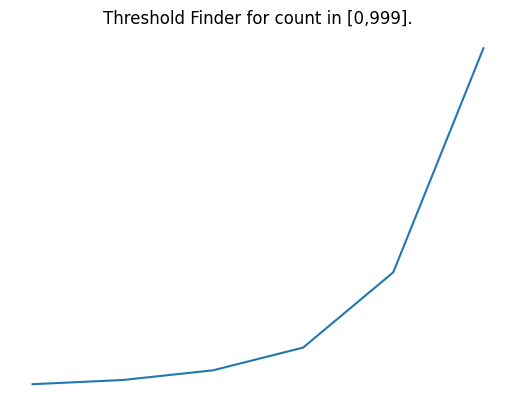

Best score is 0.12707854126764714 and best threshold is 0.9


loss: 8.08554, smth: 7.88480: 100%|██████████| 250/250 [00:43<00:00,  5.71it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.93it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


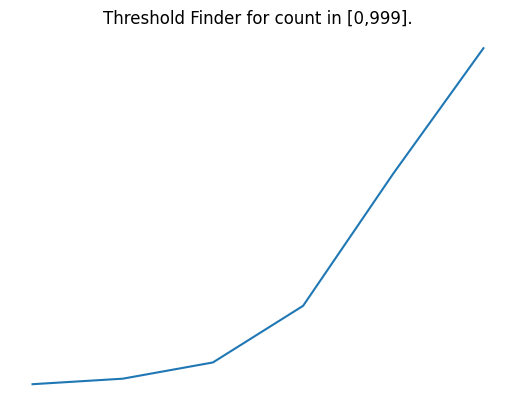

Best score is 0.7268491366291251 and best threshold is 0.9


loss: 9.02075, smth: 9.13313: 100%|██████████| 250/250 [00:43<00:00,  5.72it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.69it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


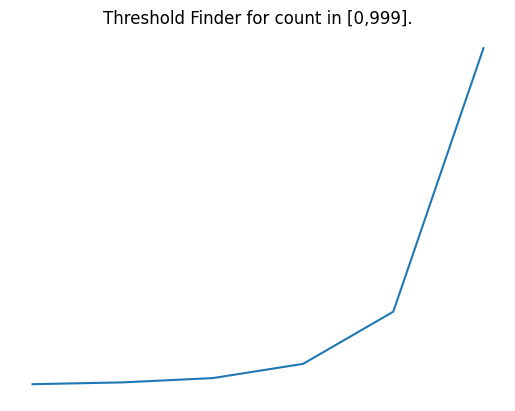

Best score is 0.1231817268448076 and best threshold is 0.9


loss: 7.91073, smth: 7.64938: 100%|██████████| 250/250 [00:43<00:00,  5.68it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.73it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


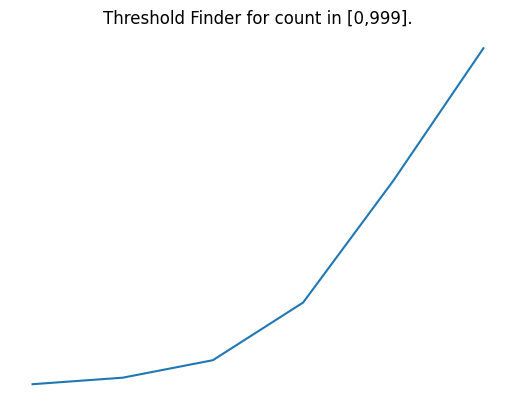

Best score is 0.6031421023397083 and best threshold is 0.9


loss: 11.50241, smth: 11.32900: 100%|██████████| 250/250 [00:44<00:00,  5.67it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00, 10.02it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


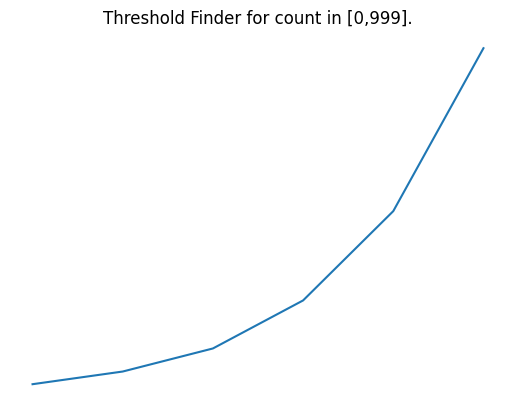

Best score is 0.03913934803260648 and best threshold is 0.9


loss: 9.74813, smth: 9.74970: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.61it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


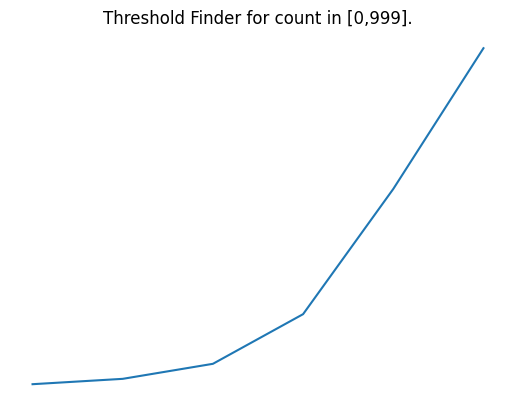

Best score is 0.68724634085246 and best threshold is 0.9


loss: 10.44025, smth: 10.38625: 100%|██████████| 250/250 [00:43<00:00,  5.69it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.68it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


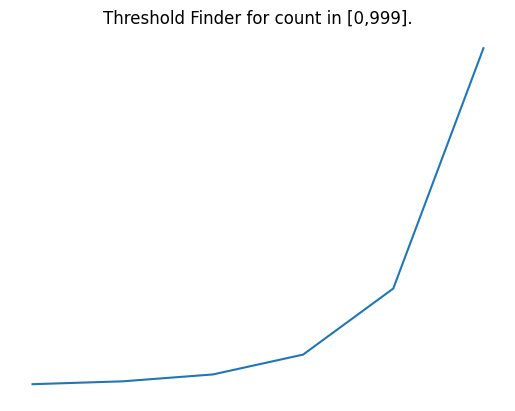

Best score is 0.09535311271519749 and best threshold is 0.9


loss: 9.49001, smth: 9.45732: 100%|██████████| 250/250 [00:43<00:00,  5.69it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.94it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


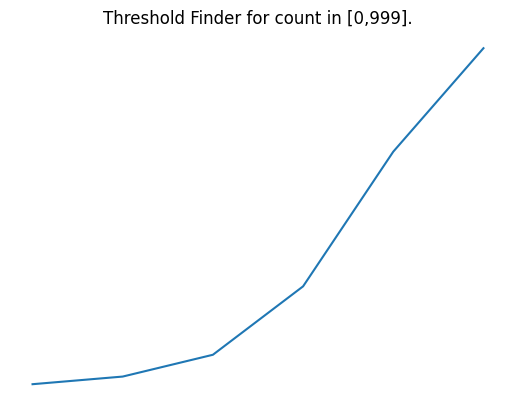

Best score is 0.7893433077778877 and best threshold is 0.9


loss: 11.01807, smth: 10.97740: 100%|██████████| 250/250 [00:43<00:00,  5.68it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.66it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


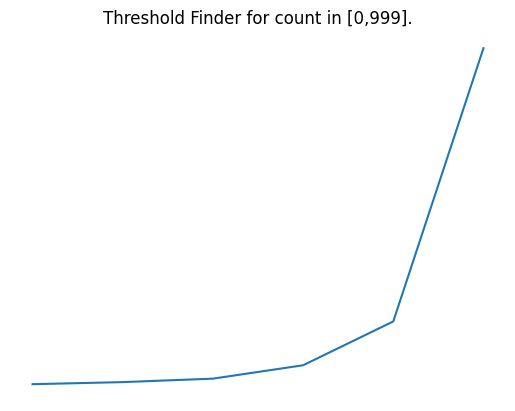

Best score is 0.01631028576908264 and best threshold is 0.9


loss: 10.09152, smth: 10.37275: 100%|██████████| 250/250 [00:44<00:00,  5.66it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00, 10.00it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


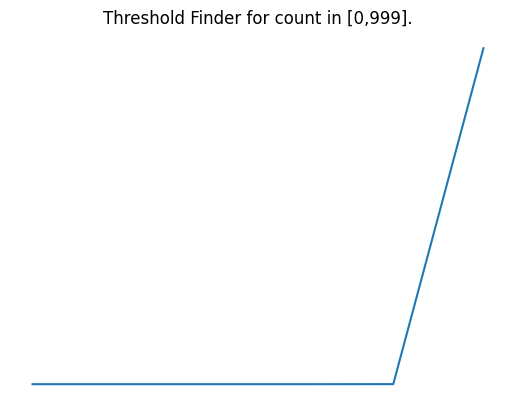

Best score is 0.0037830654107999166 and best threshold is 0.9


loss: 12.84877, smth: 12.03351: 100%|██████████| 250/250 [00:44<00:00,  5.68it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.71it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


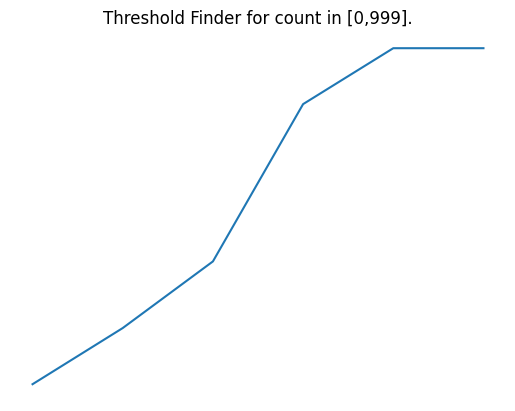

Best score is 0.00537783163274268 and best threshold is 0.8


loss: 10.82675, smth: 11.08738: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.73it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


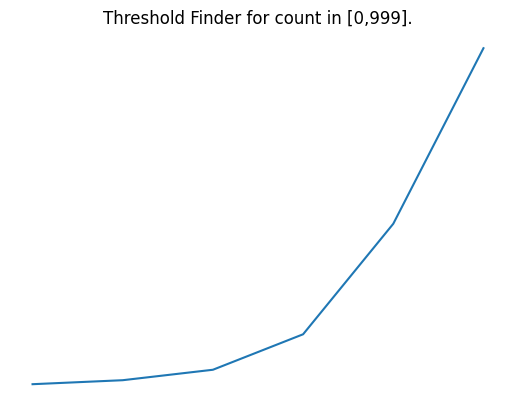

Best score is 0.7051247597418123 and best threshold is 0.9


loss: 13.08035, smth: 13.13222: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.48it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


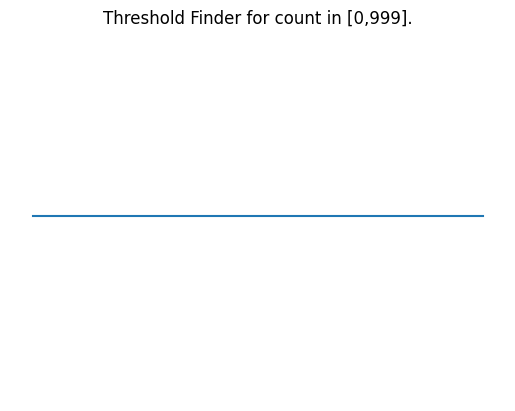

Best score is 0.003375089746340261 and best threshold is 0.4


loss: 12.90073, smth: 12.63975: 100%|██████████| 250/250 [00:44<00:00,  5.66it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.88it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


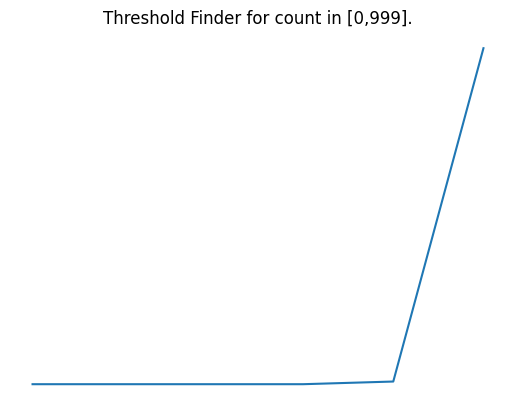

Best score is 0.003911241315077661 and best threshold is 0.9


loss: 10.10069, smth: 11.11223: 100%|██████████| 250/250 [00:44<00:00,  5.66it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.87it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


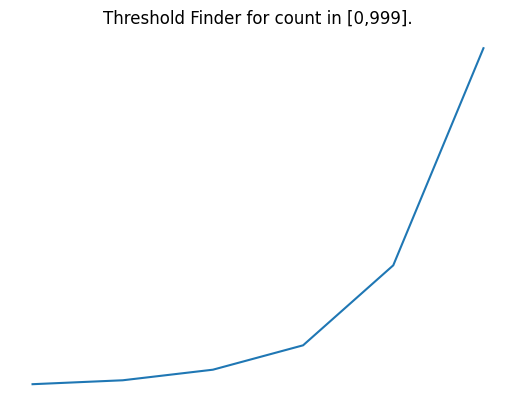

Best score is 0.08964575599962339 and best threshold is 0.9


loss: 11.15677, smth: 10.43840: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.63it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


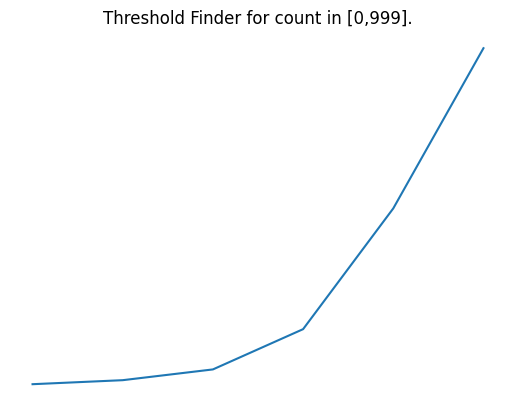

Best score is 0.6992747070555176 and best threshold is 0.9


loss: 15.64538, smth: 15.44868: 100%|██████████| 250/250 [00:44<00:00,  5.68it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.76it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


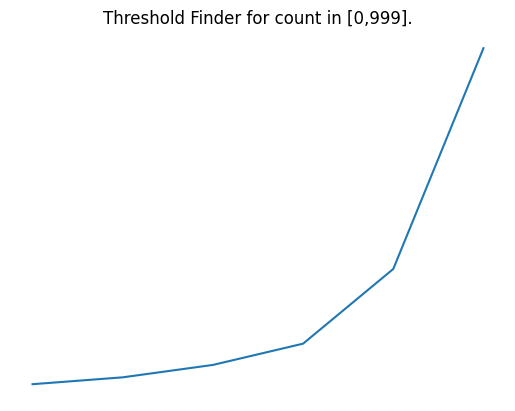

Best score is 0.051873219875243765 and best threshold is 0.9


loss: 14.85438, smth: 14.57351: 100%|██████████| 250/250 [00:44<00:00,  5.66it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.61it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


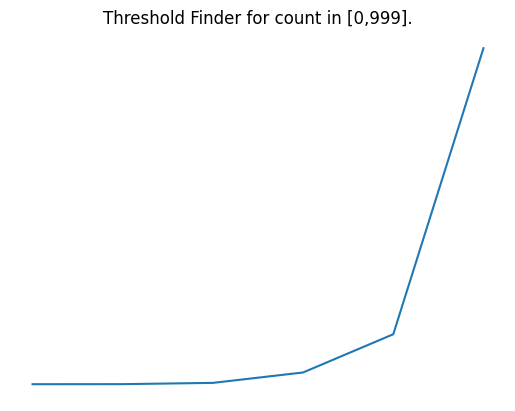

Best score is 0.028711474588298074 and best threshold is 0.9


loss: 10.40201, smth: 10.77186: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.90it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


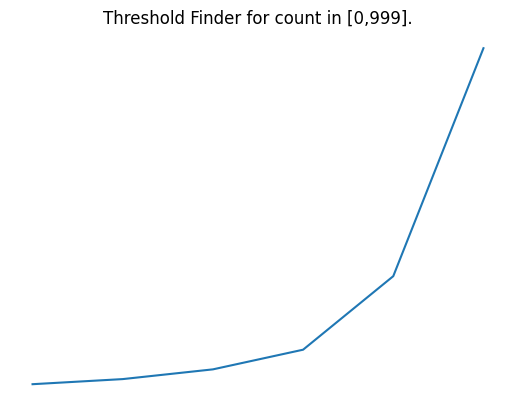

Best score is 0.04711965220214202 and best threshold is 0.9


loss: 8.66941, smth: 9.44816: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.67it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


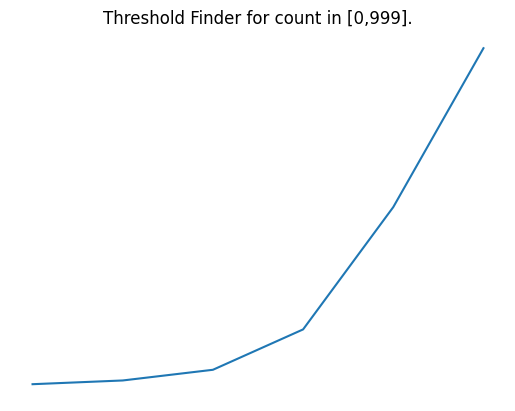

Best score is 0.7436661858221753 and best threshold is 0.9


loss: 11.90932, smth: 12.03952: 100%|██████████| 250/250 [00:44<00:00,  5.64it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.76it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


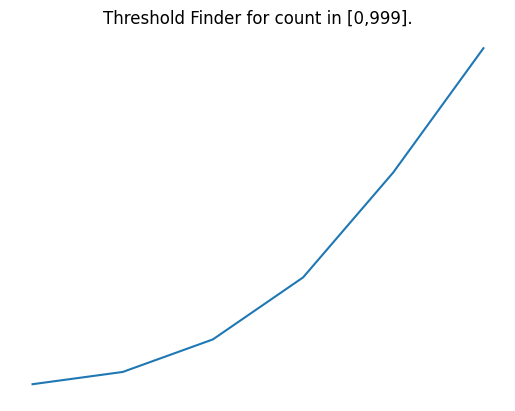

Best score is 0.06014916289118847 and best threshold is 0.9


loss: 10.02908, smth: 10.13738: 100%|██████████| 250/250 [00:44<00:00,  5.66it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.60it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


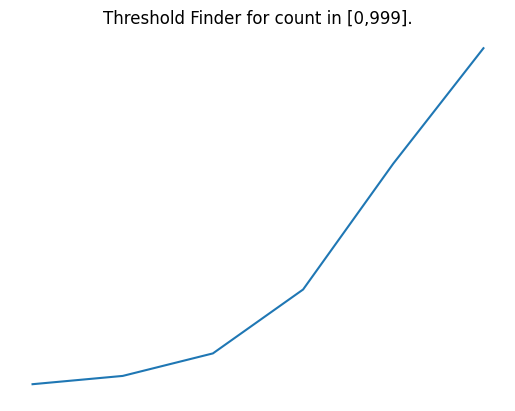

Best score is 0.5959201573050015 and best threshold is 0.9


loss: 11.53172, smth: 11.12886: 100%|██████████| 250/250 [00:44<00:00,  5.67it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.62it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


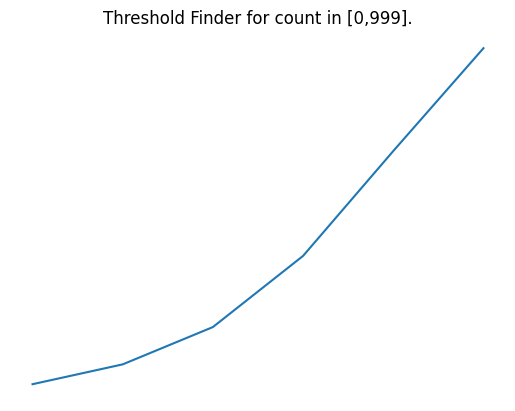

Best score is 0.07718487167379297 and best threshold is 0.9


loss: 9.67521, smth: 9.48063: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.64it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


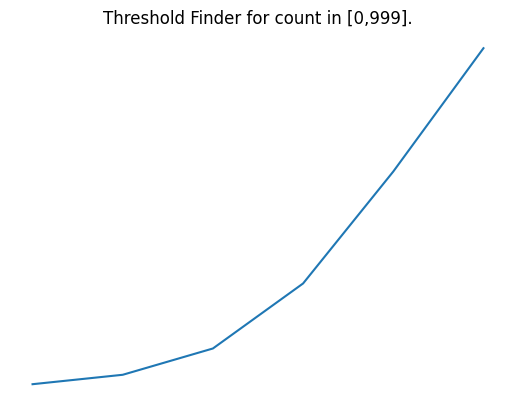

Best score is 0.573915503650976 and best threshold is 0.9


loss: 17.59618, smth: 17.83797: 100%|██████████| 250/250 [00:44<00:00,  5.66it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.42it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


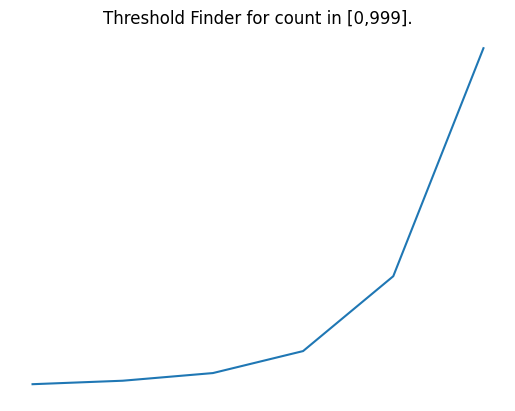

Best score is 0.31563606818136364 and best threshold is 0.9


loss: 15.70055, smth: 15.38462: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.91it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


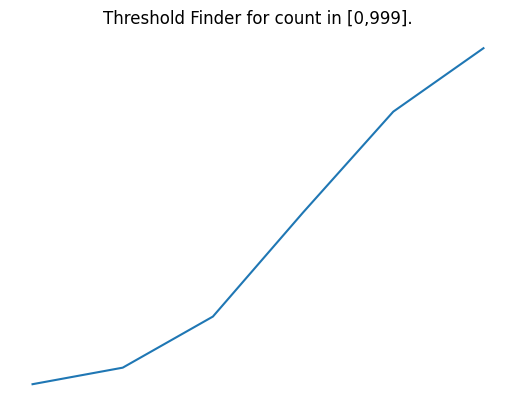

Best score is 0.7561074861040591 and best threshold is 0.9


loss: 16.07119, smth: 15.18026: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.91it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


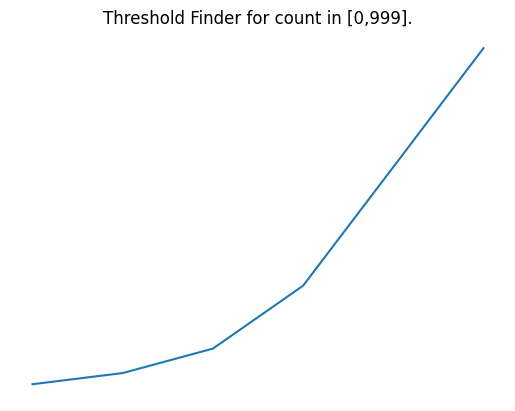

Best score is 0.11720238645203947 and best threshold is 0.9


loss: 15.21769, smth: 15.12553: 100%|██████████| 250/250 [00:44<00:00,  5.62it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.62it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


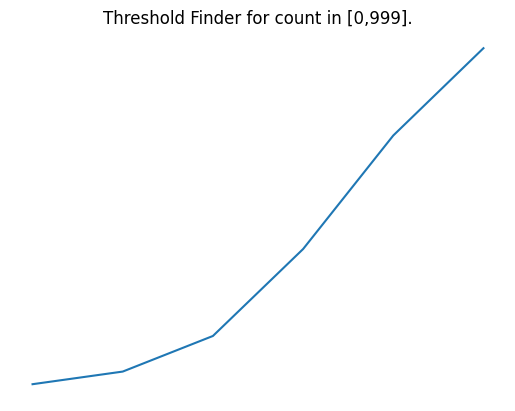

Best score is 0.714876184796516 and best threshold is 0.9


loss: 23.09046, smth: 23.31423: 100%|██████████| 250/250 [00:44<00:00,  5.64it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.93it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


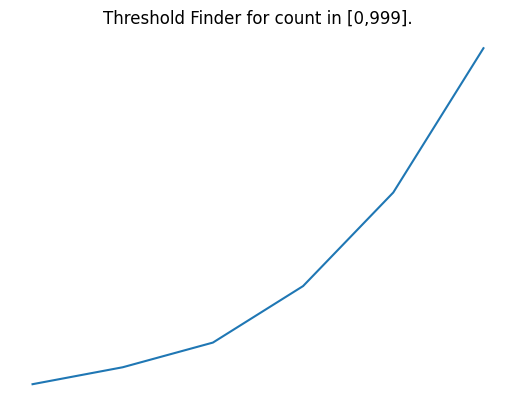

Best score is 0.038490273941483646 and best threshold is 0.9


loss: 16.91437, smth: 17.03402: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.52it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


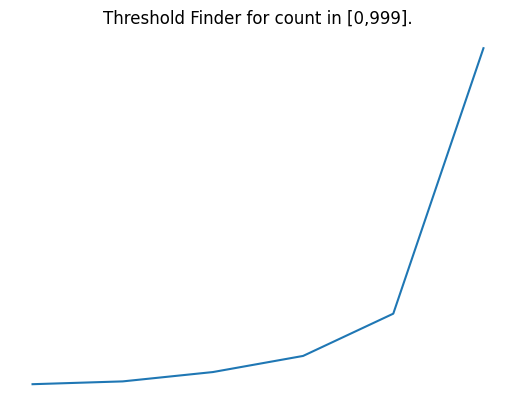

Best score is 0.0070839757372173585 and best threshold is 0.9


loss: 17.96635, smth: 18.61289: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.47it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


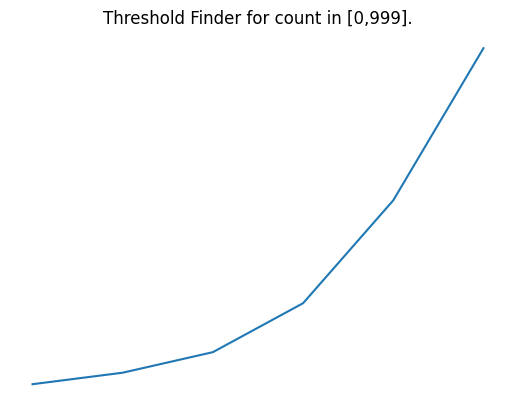

Best score is 0.11881527244911726 and best threshold is 0.9


loss: 17.85536, smth: 17.68363: 100%|██████████| 250/250 [00:44<00:00,  5.62it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.93it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


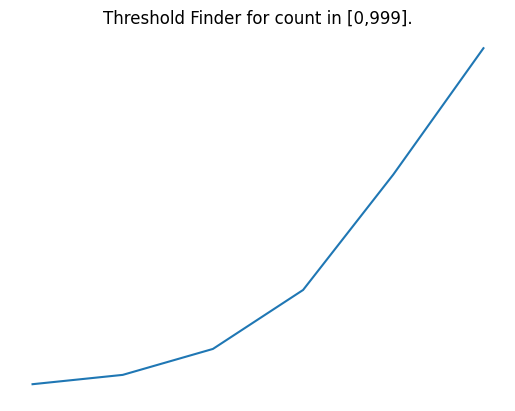

Best score is 0.6045426110626806 and best threshold is 0.9


loss: 22.51532, smth: 23.71028: 100%|██████████| 250/250 [00:44<00:00,  5.64it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.64it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


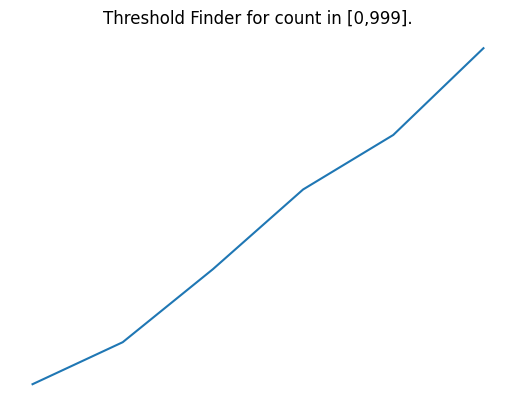

Best score is 0.005736470988205791 and best threshold is 0.9


loss: 21.21854, smth: 21.29273: 100%|██████████| 250/250 [00:44<00:00,  5.62it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.92it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


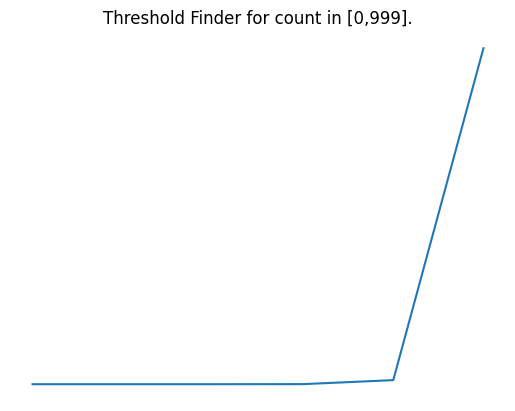

Best score is 0.005682525661347279 and best threshold is 0.9


loss: 20.86700, smth: 22.41661: 100%|██████████| 250/250 [00:44<00:00,  5.60it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00, 10.01it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


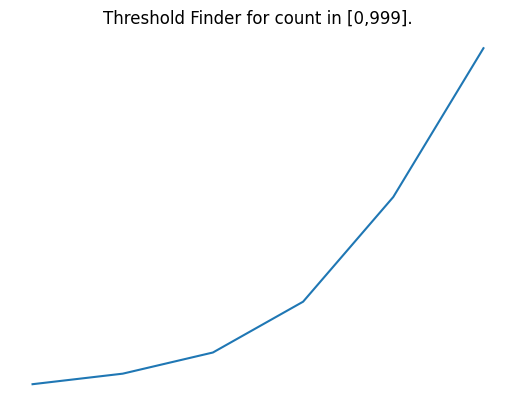

Best score is 0.1966577191149998 and best threshold is 0.9


loss: 19.36099, smth: 17.69870: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.69it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


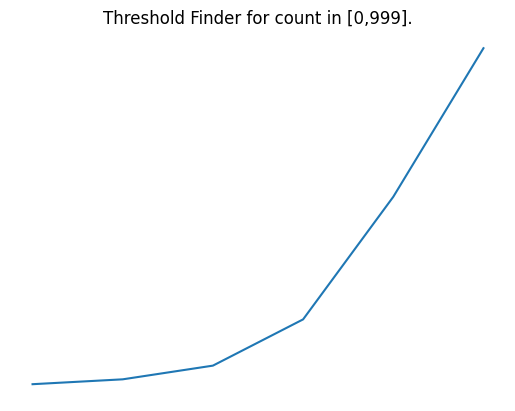

Best score is 0.6757413138651791 and best threshold is 0.9


loss: 30.94771, smth: 30.76219: 100%|██████████| 250/250 [00:44<00:00,  5.64it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.58it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


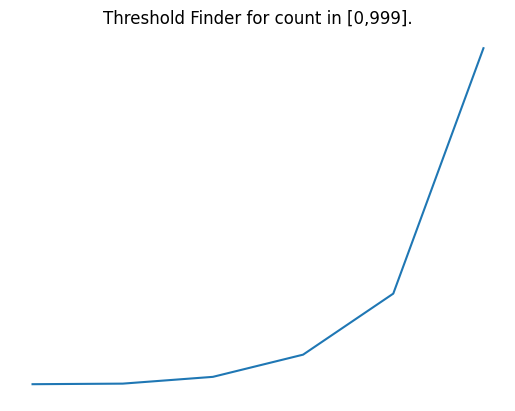

Best score is 0.0478683004500814 and best threshold is 0.9


loss: 28.74794, smth: 28.38676: 100%|██████████| 250/250 [00:44<00:00,  5.62it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.88it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


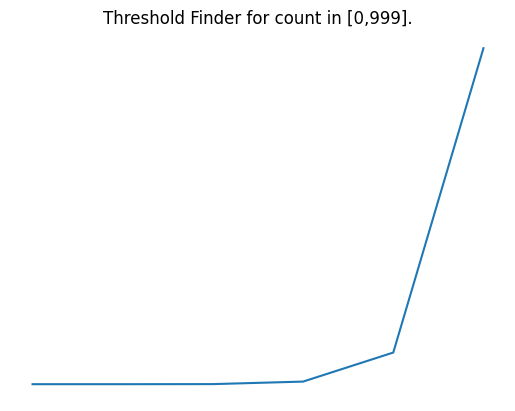

Best score is 0.03234638873945805 and best threshold is 0.9


loss: 20.67393, smth: 21.94523: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.93it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


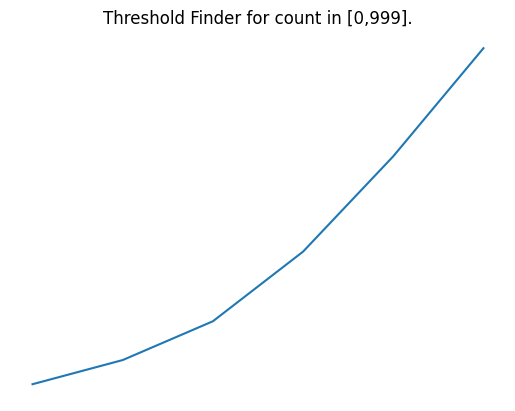

Best score is 0.07331279349783129 and best threshold is 0.9


loss: 12.63953, smth: 12.94542: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.52it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


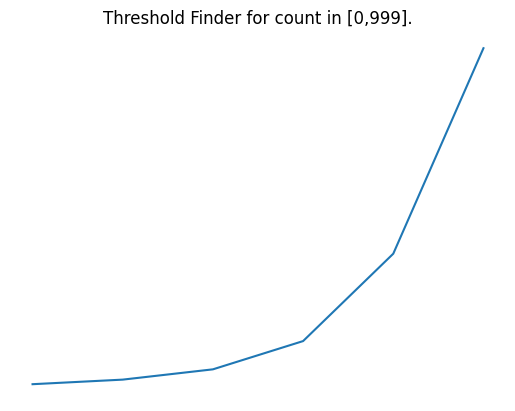

Best score is 0.3149522930346664 and best threshold is 0.9


loss: 14.77247, smth: 14.91551: 100%|██████████| 250/250 [00:44<00:00,  5.64it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.85it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


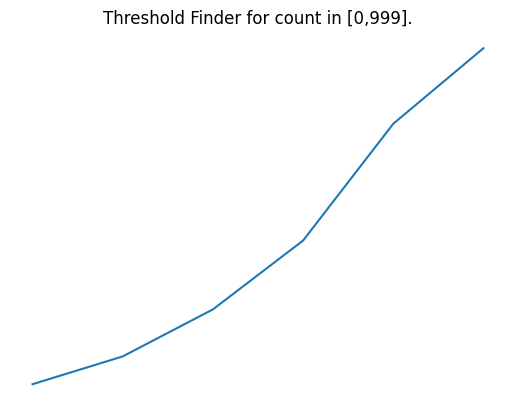

Best score is 0.10148702266279519 and best threshold is 0.9


loss: 12.96645, smth: 12.79527: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.63it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


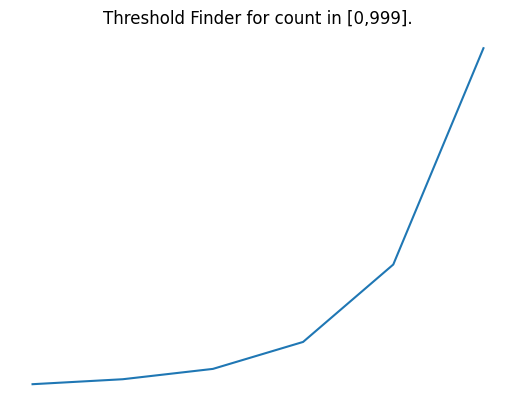

Best score is 0.384003124903937 and best threshold is 0.9


loss: 13.75952, smth: 13.04105: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.80it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


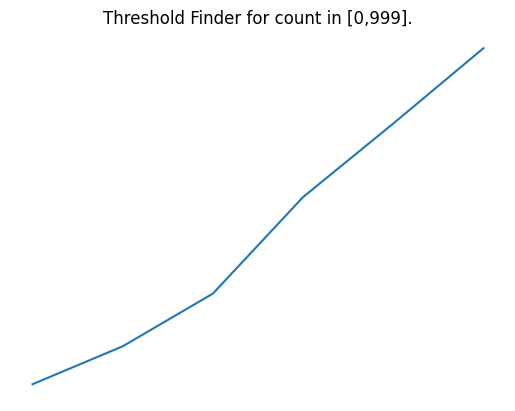

Best score is 0.04033913837125643 and best threshold is 0.9


loss: 11.46526, smth: 11.40811: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.50it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


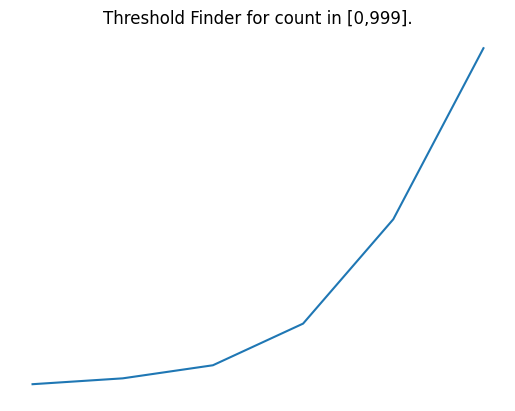

Best score is 0.41339876428764355 and best threshold is 0.9


loss: 24.49399, smth: 24.62558: 100%|██████████| 250/250 [00:44<00:00,  5.64it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.81it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


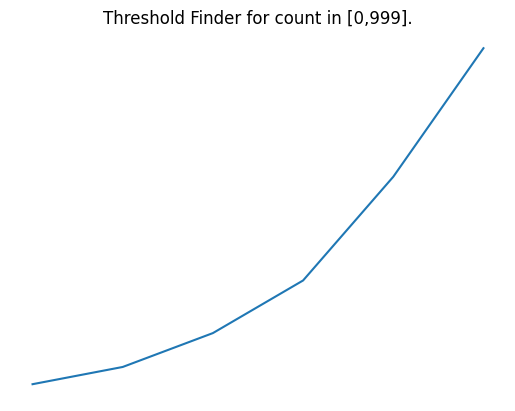

Best score is 0.15294334165422827 and best threshold is 0.9


loss: 22.34056, smth: 22.38582: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.63it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


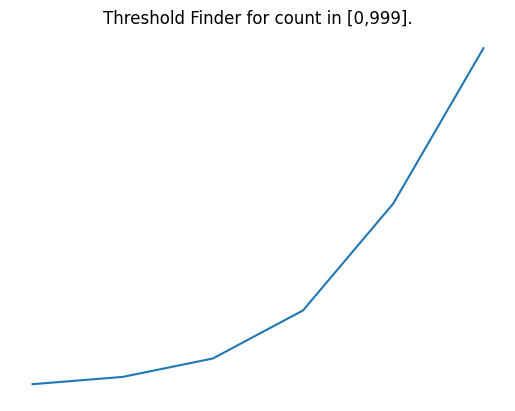

Best score is 0.41625596494699296 and best threshold is 0.9


loss: 17.84917, smth: 18.36818: 100%|██████████| 250/250 [00:44<00:00,  5.64it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.65it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


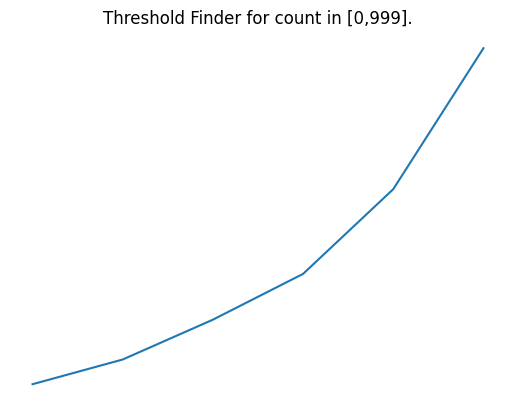

Best score is 0.04123187754576038 and best threshold is 0.9


loss: 18.96595, smth: 18.71290: 100%|██████████| 250/250 [00:44<00:00,  5.62it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.64it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:03<00:00,  1.59it/s]


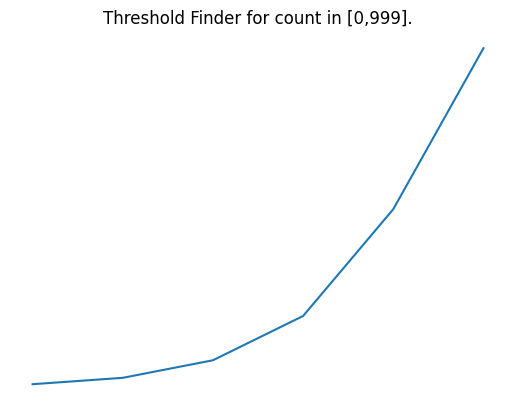

Best score is 0.5068649903541504 and best threshold is 0.9


loss: 33.48636, smth: 33.74090: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 63/63 [00:06<00:00,  9.74it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


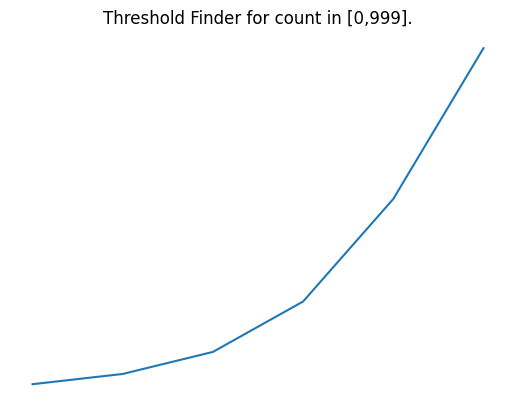

Best score is 0.3281742666860688 and best threshold is 0.9


loss: 33.36351, smth: 33.32925:  37%|███▋      | 93/250 [00:17<00:29,  5.38it/s]


KeyboardInterrupt: ignored

In [ ]:
batch_size = [16]
init_lr = [0.1, 0.01, 0.001, 0.0001]
dropout = [0.5]
scale = [10, 30, 50, 70, 90]
margin = [0.1, 0.3, 0.5, 0.7, 0.9]
easy_margin = [False, True]

for bs in batch_size:
	for lr in init_lr:
		for dp in dropout:
			for sc in scale:
				for mg in margin:
					for em in easy_margin:
						CFG.batch_size = bs
						CFG.init_lr = lr
						CFG.dropout = dp
						CFG.scale = sc
						CFG.margin = mg
						CFG.easy_margin = em

						model = DenseNet(CFG.image_size, df_train.label_group.nunique(), CFG.dropout, s=CFG.scale, m=CFG.margin, easy_margin=CFG.easy_margin)
						model.to(device);

						optimizer = optim.Adam(model.parameters(), lr=CFG.init_lr)
						scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.n_epochs, eta_min=1e-6)
						criterion = nn.CrossEntropyLoss()

						train_loader = DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.n_worker)
						valid_loader = DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.n_worker)

						for epoch in range(CFG.n_epochs):
							scheduler.step()
							loss_train = train_func(train_loader, model, criterion, optimizer, device, debug=CFG.debug)
							if epoch % CFG.valid_every == 0: 
								print('Now generating features for the validation set to simulate the submission.')
								FEAS = generate_test_features(valid_loader, model, device)
								FEAS = torch.tensor(FEAS).cuda()
								print('Finding Best Threshold in the given search space.')
								find_threshold(
									df = valid, 
									lower_count_thresh = 0, 
									upper_count_thresh = 999,
									search_space = CFG.search_space,
									FEAS = FEAS
								)
								if epoch >= CFG.save_after:
									torch.save(model.state_dict(), f'{CFG.model_dir}{CFG.kernel_type}_fold{CFG.fold_id}_densenet_{CFG.image_size}_epoch{epoch}.pth')

### Best Model

loss: 11.02172, smth: 11.89558: 100%|██████████| 1713/1713 [1:03:21<00:00,  2.22s/it]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [19:26<00:00,  2.72s/it]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:19<00:00,  3.17s/it]


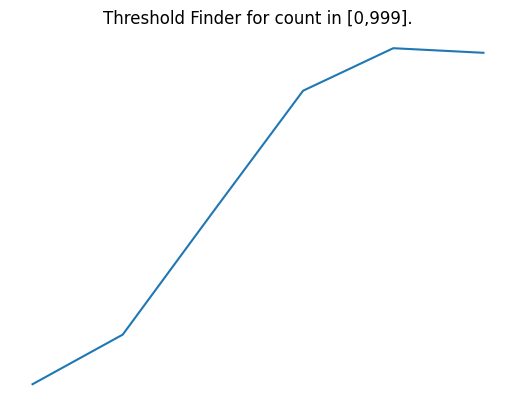

Best score is 0.6427858541169491 and best threshold is 0.8


loss: 9.64625, smth: 10.17522: 100%|██████████| 1713/1713 [04:55<00:00,  5.80it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.33it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:17<00:00,  2.94s/it]


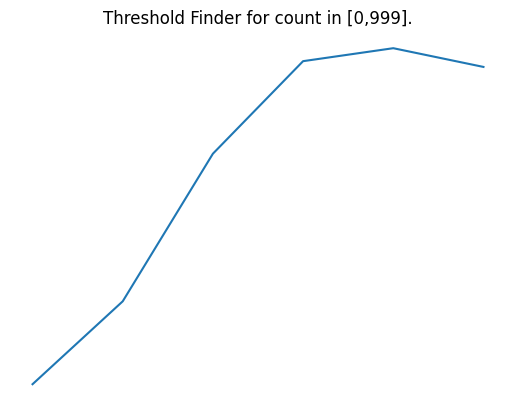

Best score is 0.6690997452077847 and best threshold is 0.8


loss: 10.26047, smth: 8.82030: 100%|██████████| 1713/1713 [04:57<00:00,  5.76it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.40it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:17<00:00,  2.86s/it]


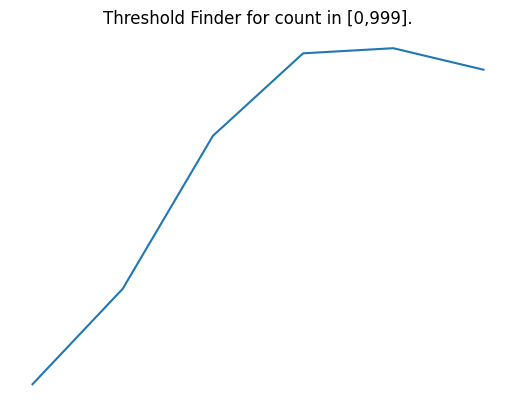

Best score is 0.6771544934302842 and best threshold is 0.8


loss: 8.91718, smth: 7.94951: 100%|██████████| 1713/1713 [04:57<00:00,  5.76it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.34it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.81s/it]


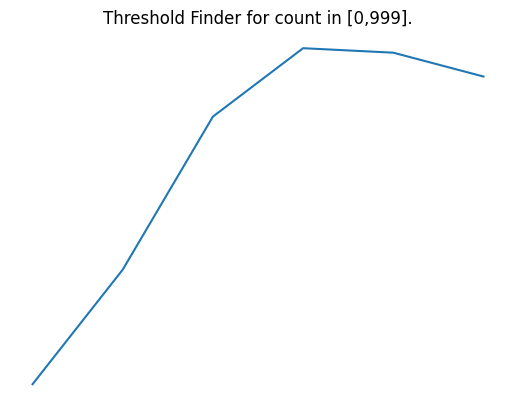

Best score is 0.6891779714438687 and best threshold is 0.7


loss: 8.53572, smth: 7.36527: 100%|██████████| 1713/1713 [05:00<00:00,  5.70it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.31it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


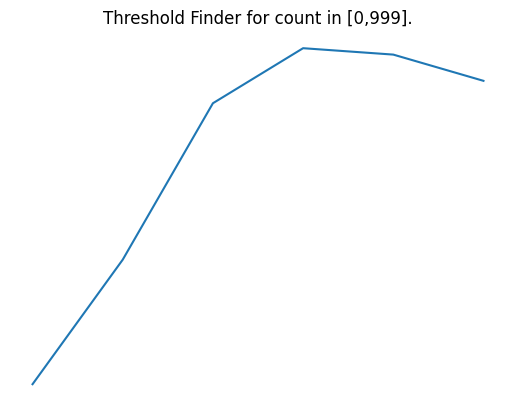

Best score is 0.700001637606007 and best threshold is 0.7


loss: 8.29827, smth: 6.92536: 100%|██████████| 1713/1713 [04:57<00:00,  5.75it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.34it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


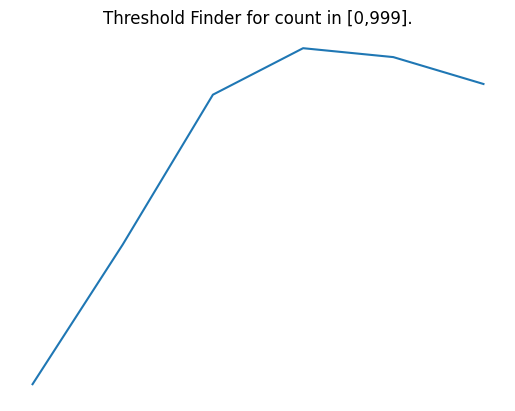

Best score is 0.7022443135856014 and best threshold is 0.7


loss: 6.76431, smth: 6.68436: 100%|██████████| 1713/1713 [04:58<00:00,  5.75it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.34it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


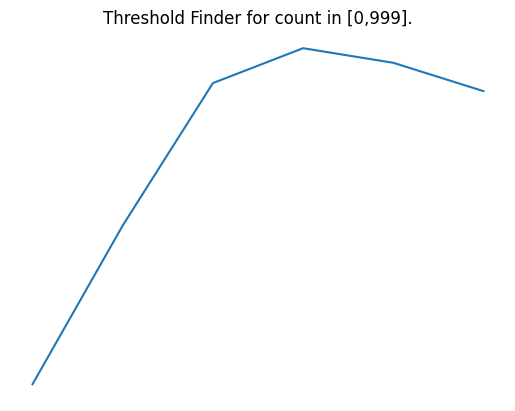

Best score is 0.7109990980424014 and best threshold is 0.7


loss: 7.72884, smth: 6.44588: 100%|██████████| 1713/1713 [04:57<00:00,  5.76it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:42<00:00, 10.17it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.73s/it]


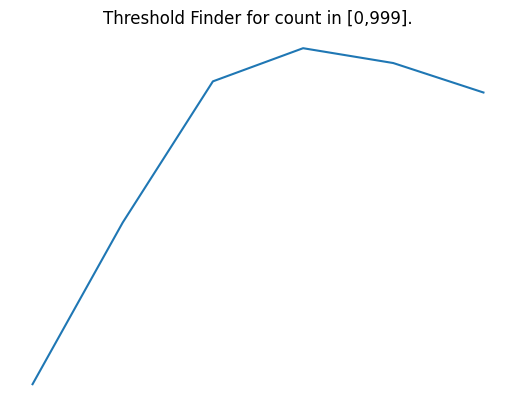

Best score is 0.7163567153819382 and best threshold is 0.7


loss: 5.47638, smth: 6.20832: 100%|██████████| 1713/1713 [04:58<00:00,  5.74it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.31it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


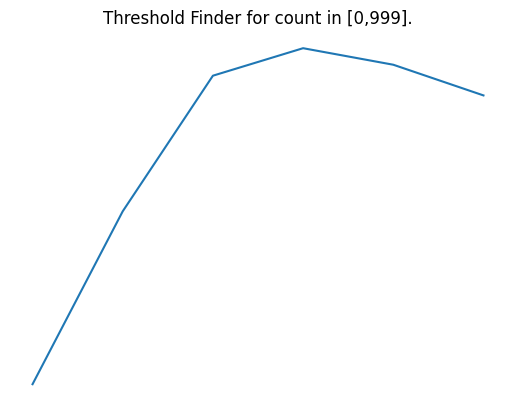

Best score is 0.7186703090535408 and best threshold is 0.7


loss: 6.91855, smth: 5.88504: 100%|██████████| 1713/1713 [04:58<00:00,  5.74it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.31it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:15<00:00,  2.67s/it]


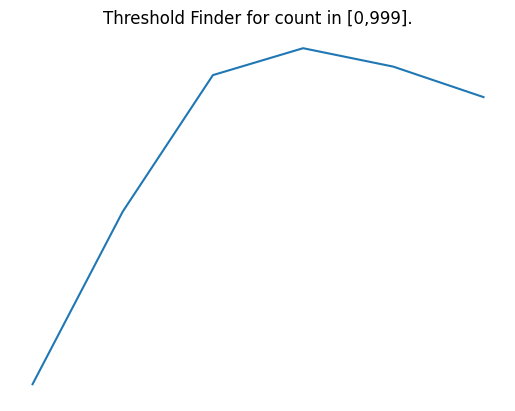

Best score is 0.7232111064256825 and best threshold is 0.7


loss: 6.06629, smth: 5.87949: 100%|██████████| 1713/1713 [04:57<00:00,  5.76it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.26it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


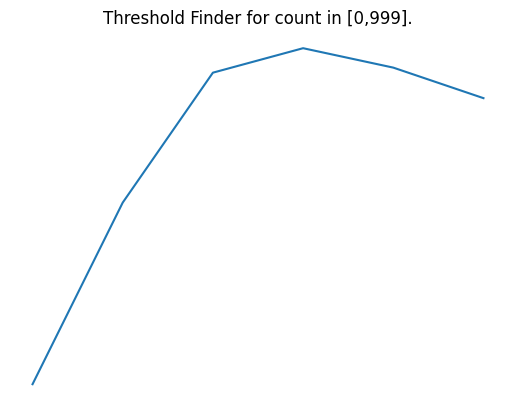

Best score is 0.7241198526200454 and best threshold is 0.7


loss: 6.16116, smth: 5.72424: 100%|██████████| 1713/1713 [04:57<00:00,  5.76it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.30it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


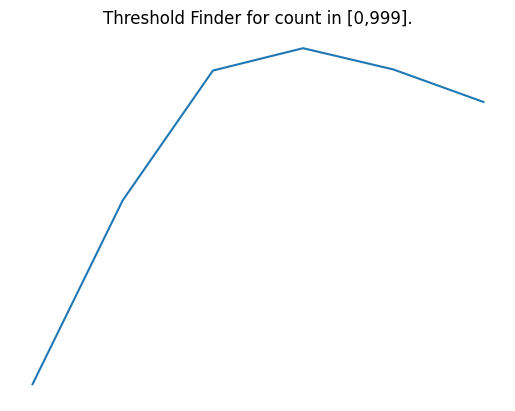

Best score is 0.7293313386996325 and best threshold is 0.7


loss: 7.28156, smth: 5.70238: 100%|██████████| 1713/1713 [04:58<00:00,  5.74it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.23it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.73s/it]


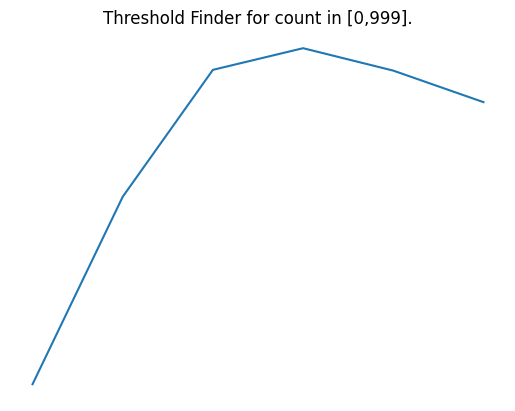

Best score is 0.7300445047590234 and best threshold is 0.7


loss: 7.27372, smth: 5.54026: 100%|██████████| 1713/1713 [04:58<00:00,  5.74it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.36it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


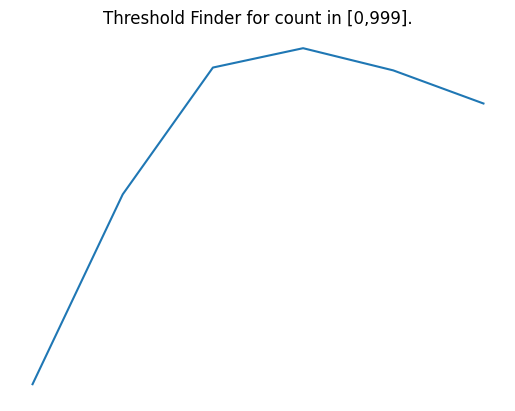

Best score is 0.731724975765662 and best threshold is 0.7


loss: 6.03357, smth: 5.51203: 100%|██████████| 1713/1713 [04:58<00:00,  5.74it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.23it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


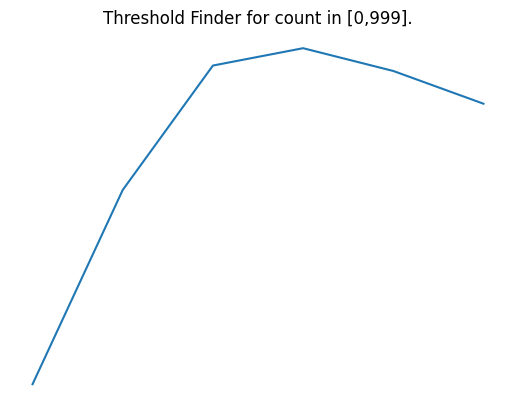

Best score is 0.7309105547549212 and best threshold is 0.7


loss: 5.92847, smth: 5.39334: 100%|██████████| 1713/1713 [05:00<00:00,  5.69it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.24it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


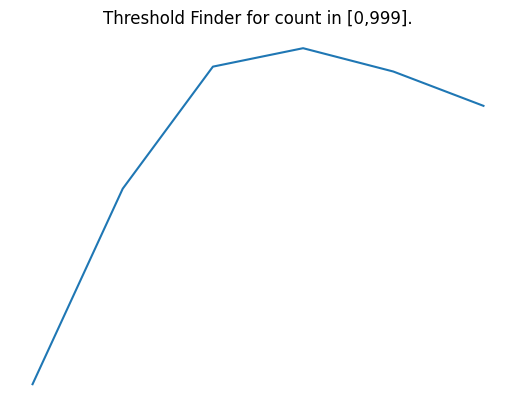

Best score is 0.7337507145377284 and best threshold is 0.7


loss: 5.87277, smth: 5.33916: 100%|██████████| 1713/1713 [04:58<00:00,  5.73it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.22it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


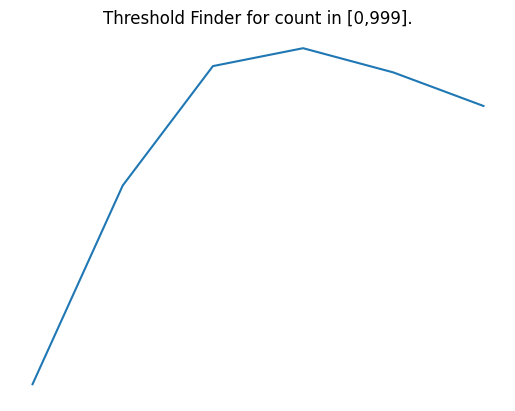

Best score is 0.734942750218887 and best threshold is 0.7


loss: 6.12386, smth: 5.38606: 100%|██████████| 1713/1713 [04:59<00:00,  5.71it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.24it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


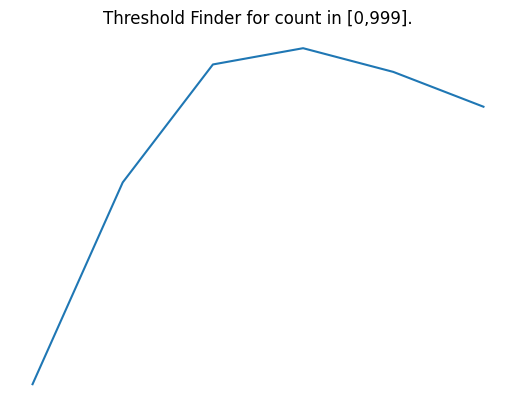

Best score is 0.734095434710931 and best threshold is 0.7


loss: 6.23384, smth: 5.12846: 100%|██████████| 1713/1713 [04:59<00:00,  5.71it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.23it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


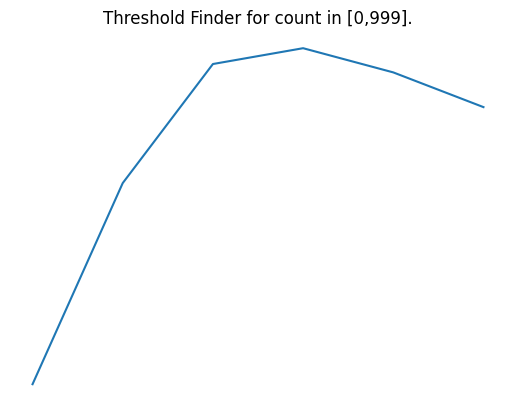

Best score is 0.7346819732939469 and best threshold is 0.7


loss: 6.03870, smth: 5.12199: 100%|██████████| 1713/1713 [04:59<00:00,  5.72it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:42<00:00, 10.21it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


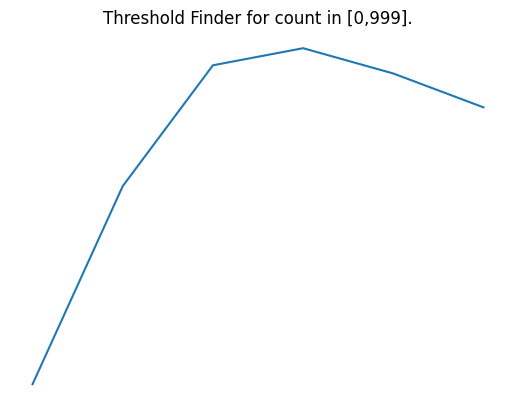

Best score is 0.736760758195342 and best threshold is 0.7


loss: 5.48392, smth: 5.10867: 100%|██████████| 1713/1713 [05:00<00:00,  5.70it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:42<00:00, 10.13it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


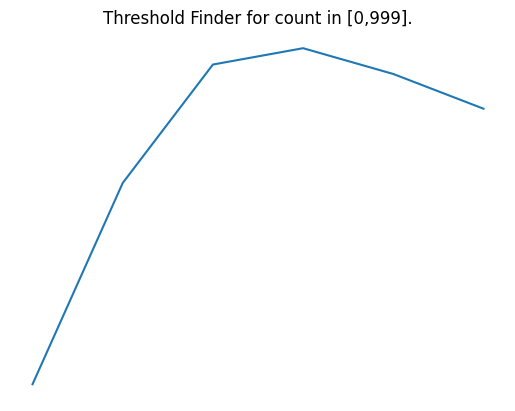

Best score is 0.7376344992568159 and best threshold is 0.7


loss: 5.75569, smth: 5.10809: 100%|██████████| 1713/1713 [04:59<00:00,  5.71it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.23it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


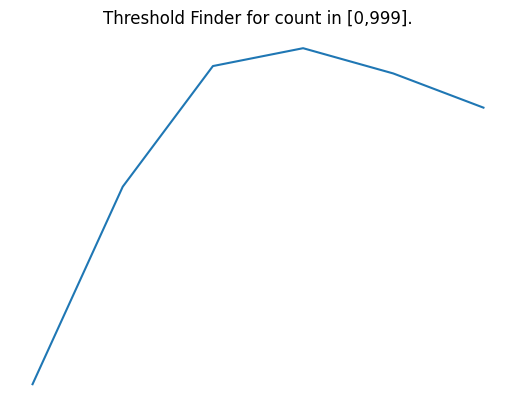

Best score is 0.7377327531553759 and best threshold is 0.7


loss: 5.62026, smth: 5.13563: 100%|██████████| 1713/1713 [05:00<00:00,  5.70it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:42<00:00, 10.21it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


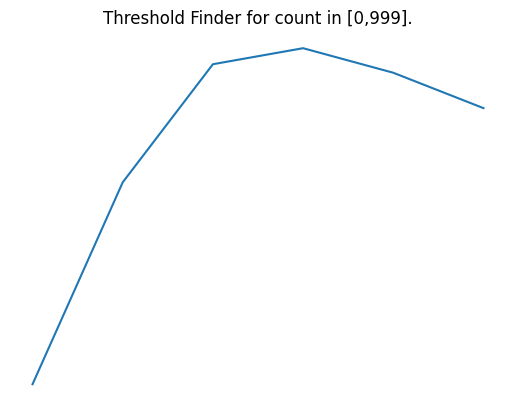

Best score is 0.7365079171217168 and best threshold is 0.7


loss: 5.68378, smth: 5.00781: 100%|██████████| 1713/1713 [05:01<00:00,  5.69it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:42<00:00, 10.03it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


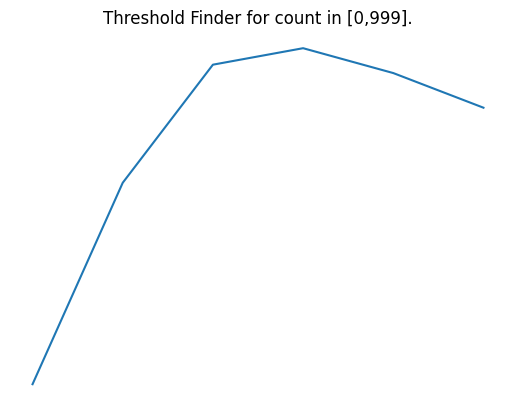

Best score is 0.7358951448041721 and best threshold is 0.7


loss: 6.39854, smth: 4.99519: 100%|██████████| 1713/1713 [05:00<00:00,  5.70it/s]


Now generating features for the validation set to simulate the submission.


100%|██████████| 429/429 [00:41<00:00, 10.25it/s]


Finding Best Threshold in the given search space.


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


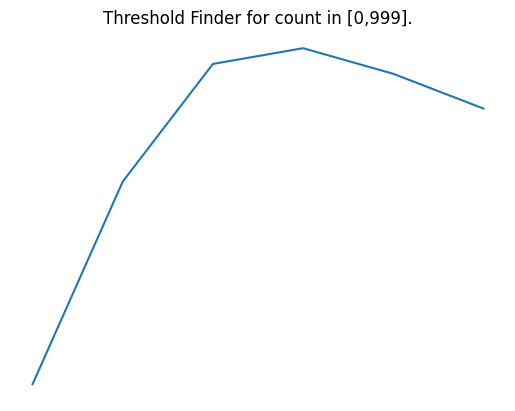

Best score is 0.7374672966976245 and best threshold is 0.7


In [9]:
train_loader = DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.n_worker)
valid_loader = DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.n_worker)

model = DenseNet(CFG.image_size, df_train.label_group.nunique(), CFG.dropout, s=CFG.scale, m=CFG.margin, easy_margin=CFG.easy_margin)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CFG.init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.n_epochs)

for epoch in range(CFG.n_epochs):
    scheduler.step()
    loss_train = train_func(train_loader, model, criterion, optimizer, device, debug=CFG.debug)
    if epoch % CFG.valid_every == 0: 
        print('Now generating features for the validation set to simulate the submission.')
        FEAS = generate_test_features(valid_loader, model, device)
        FEAS = torch.tensor(FEAS).cuda()
        print('Finding Best Threshold in the given search space.')
        find_threshold(
            df = valid, 
			lower_count_thresh = 0, 
			upper_count_thresh = 999,
			search_space = CFG.search_space,
            FEAS = FEAS
        )
        if epoch >= CFG.save_after:
            torch.save(model.state_dict(), f'{CFG.model_dir}{CFG.kernel_type}_fold{CFG.fold_id}_densenet_{CFG.image_size}_epoch{epoch}.pth')